# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

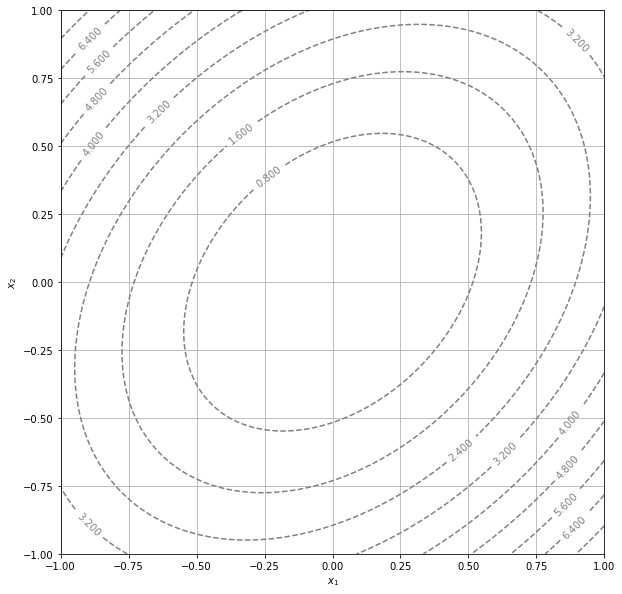

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

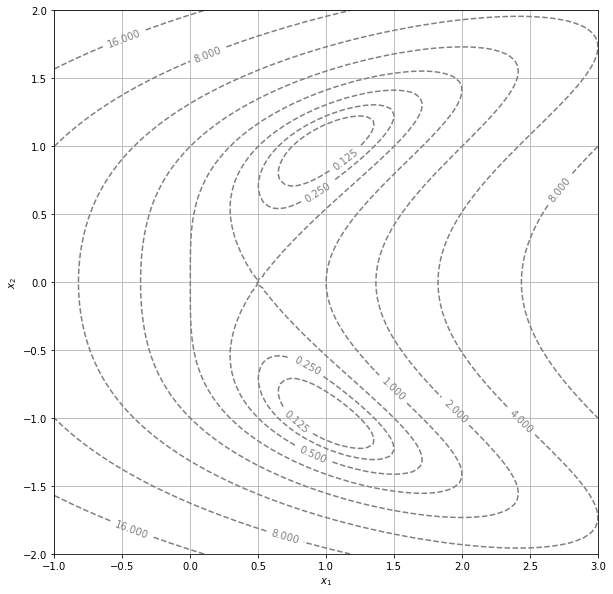

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

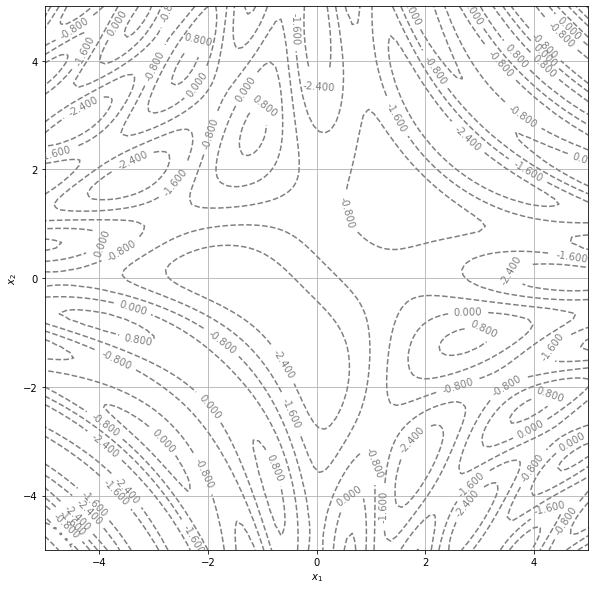

In [30]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### Réponse 1
Soit $c \lt \min\limits_{x \in \mathbb{R}^2} f(x_1,x_2)$ et $\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}=\varnothing $ \
Soit $c \ge \min\limits_{x \in \mathbb{R}^2} f(x_1,x_2)$ et $\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2)=c\}\neq\varnothing$\\

$ \{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\} =f^{-1}(\{c\})$, donc par le critère de l'image réciproque, comme $f$ est continue, $\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}$ est un ensemble fermé.\\

Par l'absurde, si $\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}$ n'était pas borné, $\forall n \in \mathbb{N}$, il existerait $x_n \in \{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}$ tel que $\|x_n\| \geq n$, on aurait par continuité $ \lim\limits_{x_n \rightarrow +\infty} f(x_n)=c$ ce qui est exclu.

Donc $\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}$ est un fermé borné.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$

#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse 2
$p(x_1,x_2):=det\begin{pmatrix}
  x_1 - x_{10} & \frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \\
  x_2 - x_{20} & \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} \\
 \end{pmatrix}$\
 $p(x_1,x_2)$ donne l'aire signée du parallélogramme engendré par 
 $
 \begin{pmatrix}
 x_1 - x_{10} \\
 x_2 - x_{20}
 \end{pmatrix}$ et 
 $
 \begin{pmatrix}
 \frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \\
 \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} \\
 \end{pmatrix}$.\
$p(x_1,x_2) \gt 0$ si $(x_1,x_2)$ est à droite du gradient. \
$p(x_1,x_2) \lt 0$ si $(x_1,x_2)$ est à gauche du gradient. \
$p(x_1,x_2) = 0$ si
 $
 \begin{pmatrix}
 x_1 - x_{10} \\
 x_2 - x_{20}
 \end{pmatrix}$ et 
 $
 \begin{pmatrix}
 \frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \\
 \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} \\
 \end{pmatrix}$ sont colinéaires, c'est-à-dire si $(x_1,x_2)$ est sur la perpendiculaire à la tangente de la courbe de niveau en $(x_{10},x_{20})$, passant par $(x_{10},x_{20})$.


#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse 3
Soit $U \subset \mathbb{R}^2$ un voisinage ouvert de $x_0$ sur lequel le gradient $\nabla f$ ne s'annule pas. \
Soit $F:(x,t) \in U \times \mathbb{R} \to (f(x)-c,p(x)-t)\in \mathbb{R}^2$ \
$F$ est continûment différentiable et $\partial_x F (x,t) = 
\begin{pmatrix}
\partial_1 f(x) & \partial_2 f(x) \\
\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|}
\end{pmatrix}
$ \
$det(\partial_x F (x,t))=\partial_1 f(x)\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|}+\partial_2 f(x)\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} $ vaut ${\|\nabla f(x_0)\|} \gt 0$ en $x_0$ donc il exite un voisinage ouvert $U'$ de $x_0$ surlequel $det(\partial_x F (x,t)) \gt 0$ et donc $\partial_x F$ est inversible sur $U' \times \mathbb{R}$ \
De plus, $F(x_0,0)=(0,0)$

Alors d'après le théorème des fonctions implicites, il existe un voisinage ouvert $V$ de $x_0$ et $\varepsilon \gt 0$ tels que $V \times \left]-\varepsilon,\varepsilon \right[ \subset U' \times \mathbb{R}$ et une unique fonction implicite $\gamma : \left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ continûment différentiable, telle que $\forall (x,t) \in V \times \left]-\varepsilon,\varepsilon \right[$,
$$
F(x,t)=0 \Leftrightarrow x=\gamma(t)
$$
C'est-à-dire:
$$
\begin{cases}
f(x_1,x_2) = c \\
t = p(x_1, x_2)
\end{cases}
\Leftrightarrow
(x_1, x_2) = \gamma(t)
$$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Réponse 4

- Soit $t \in \left]-\varepsilon, \varepsilon \right[$,\
Toujours d'après le théorème des fonctions implicites:
$\gamma'(t)=-(\partial_x F(x,t))^{-1} \cdot \partial_t F(x,t)$ où $x=\gamma(t)$ \
$(\partial_x F (x,t))^{-1}= \frac{1}{det(\partial_x F (x,t))}
\begin{pmatrix}
-\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} & -\partial_2 f(x) \\
-\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & \partial_1 f(x)
\end{pmatrix}
$ \
$\partial_t F(x,t)=
\begin{pmatrix}
0\\
-1
\end{pmatrix}
$ \
$\gamma'(t)=\frac{1}{det(\partial_x F (x,t))}
\begin{pmatrix}
-\partial_2 f(x)\\
\partial_1 f(x)
\end{pmatrix}
$ \
Donc $\forall t \in \left]-\varepsilon , \varepsilon \right[$, $\gamma(t) \neq 0$ car $\nabla f$ ne s'annule pas sur $U'$
-$\left<\nabla f(\gamma(t)),\gamma'(t)\right>=\left<
\begin{pmatrix}
\partial_1 f(x)\\
\partial_2 f(x)
\end{pmatrix}
,
\frac{1}{det(\partial_x F (x,t))}
\begin{pmatrix}
-\partial_2 f(x)\\
\partial_1 f(x)
\end{pmatrix}
\right>=\frac{1}{det(\partial_x F (x,t))}\left[-\partial_1 f(x)\partial_2 f(x)+\partial_2 f(x)\partial_1 f(x)\right]=0$ (avec $x=\gamma(t)$)\
Donc $\forall t \in \left]-\varepsilon, \varepsilon \right[$, $\gamma(t)$ est orthogonal à $f(\gamma(t))$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

#### Réponse 5
Pour dessiner des courbes de niveau la précision doit être assez élevée par conséquent on choisi `eps` proche de la précision machine ($2,22.10^{-16}$)

In [14]:
N = 100
eps = 10e-15

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

#### Réponse à la tâche 1
Soit $F : \mathbb{R}^2 \to \mathbb{R}^2$ \
Soit $(x,y)$ une solution approchée de $f(x,y)=(0,0)$ proche de $(x_0,y_0)$\
On a alors $f(x,y) \approx f(x_0,y_0)+ df(x_0,y_0)(x-x_0,y-y_0) \approx 0$\
On en déduit $(x,y) \approx (x_0,y_0)-(df(x_0,y_0))^{-1}f(x_0,y_0)$\
Par itérations successives on se rapproche de la solution de $f(x,y)=(0,0)$

In [18]:
def Newton(F, x0, y0, eps=eps, N=N): #F doit retourner un array
    
    for i in range(N):
        x, y = np.array([x0, y0]) - np.dot(np.linalg.inv(J(F)(x0,y0)),F(x0,y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

#### Réponse à la tâche 2
On crée tout d'abord la fonction $F : \mathbb{R}^2 \to \mathbb{R}^2$ telle qu'elle s'annule lorsque les conditions $
\begin{cases}
f(x,y) = c \\
x=y
\end{cases}
$
sont réalisées. \
$F : (x,y) \to (f(x,y) - c , x-y)$

In [19]:
def F(f, niveau, cond, x, y):
    return np.array([f(x, y) - niveau, cond(x,y)])

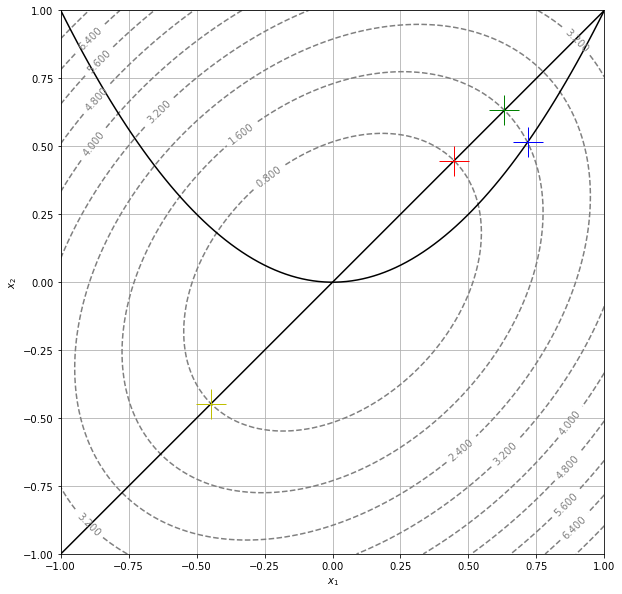

In [20]:
"""Affichage des courbes de niveau données par l'ennoncé"""

x=np.linspace(-1.0, 1.0, 100)

display_contour(f1, x, x, levels=10)

"""Affichage des courbes y = x et y = x^2 ; affichées en noir"""

plt.plot(x, x, 'k-')
plt.plot(x, x**2, 'k-')

"""Recherche d'un point de la ligne de niveau 0.8 de f1 à partir de (0.8, 0.8) et qui vérifie x = y ; affiché en rouge"""

def cond1(x, y):
    return x - y

def F1(x, y):
    return F(f1, 0.8, cond1, x, y)

x1, y1 = Newton(F1, 0.8, 0.8)
plt.plot(x1, y1, 'r+', markersize=30)

"""Recherche d'un point de la ligne de niveau 1.6 de f1 à partir de (0.8, 0.8) et qui vérifie x = y ; affiché en vert"""

def F2(x, y):
    return F(f1, 1.6, cond1, x, y)

x2, y2 = Newton(F2, 0.8, 0.8)
plt.plot(x2, y2, 'g+', markersize=30)

"""Recherche d'un point de la ligne de niveau 0.8 de f1 à partir de (-0.8, -0.8) et qui vérifie x = y ; affiché en jaune"""

x3, y3 = Newton(F1, -0.8, -0.8)
plt.plot(x3, y3, 'y+', markersize=30)

"""Recherche d'un point de la ligne de niveau 1.6 de f1 à partir de (0.8, 0.8) et qui vérifie x^2 = y ; affiché en bleu"""

def cond2(x, y):
    return y - x**2

def F3(x, y):
    return F(f1, 1.6, cond2, x, y)

x4, y4 = Newton(F3, 0.8, 0.8)
plt.plot(x4, y4, 'b+', markersize=30)

plt.show()

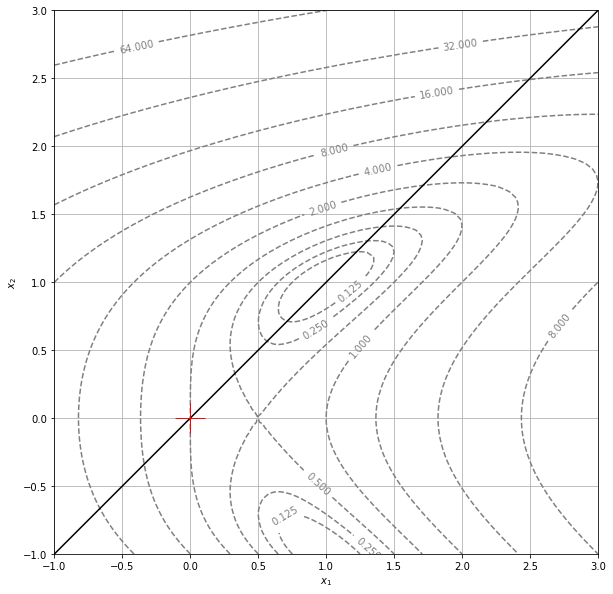

In [37]:
"""Affichage des courbes de niveau données par l'ennoncé"""

x=np.linspace(-1.0, 3.0, 100)

display_contour(f2, x, x, levels=[2**i for i in range(-3, 8)])

"""Affichage de la courbe y = x ; affichées en noir"""

plt.plot(x, x, 'k-')

"""Recherche d'un point de la ligne de niveau 1.0 de f1 à partir de (0.8, 0.8) et qui vérifie x = y ; affiché en rouge"""

def F4(x, y):
    return F(f2, 1, cond1, x, y)

x5, y5 = Newton(F4, 0.8, 0.8)  #ne marche pas en partant de (1, 1) car la jacobienne n'est pas inversible
plt.plot(x5, y5, 'r+', markersize=30)

plt.show()

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

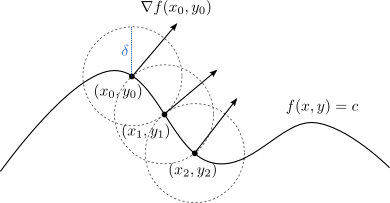

#### Réponse 6

On réutilise la fonction Newton afin de trouver un point sur la courbe de niveau, mais cette fois on crée une fonction $F : \mathbb{R}^2 \to \mathbb{R}^2$ qui prend pour deuxième élément la condition $(x - x_0)^2 + (y-y_0)^2 =\delta^2 $. Cependant, pour être sûr de partir "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$, on prend comme point initial dans la fonction de Newton : $ (x_d, y_d) = (x_0, y_0) - \delta \times \frac{u}{\left \| u \right \|}$ avec $u = \begin{pmatrix}
0 & 1 \\
-1 & 0
\end{pmatrix}\times \nabla f(x_0, y_0)$ la rotation de $-\frac{\pi}{2}$ du gradient en $(x_0, y_0)$.\
$(x_d, y_d)$ est à distance $\delta$ de $(x_0, y_0)$.


In [22]:
def level_curve(f, x0, y0, delta=0.1, N=100, eps=eps):
    L = np.empty((2,N))
   
    for i in range(N):
        g = grad(f)(x0, y0)
        rotation = np.array([[0, 1],[-1, 0]])
        u = np.dot(rotation,g)
        xd, yd = np.array([x0, y0]) + delta * u / (np.linalg.norm(u))
        
        def cond4(x, y):
            return (x - x0)**2 + (y - y0)**2 - delta**2

        def F5(x, y):
            return F(f, f(x0, y0), cond4, x, y)
    
        newt = Newton(F5 ,xd, yd)
        x0, y0 = newt[0], newt[1]
        L[0][i] = x0
        L[1][i] = y0
         
    return L

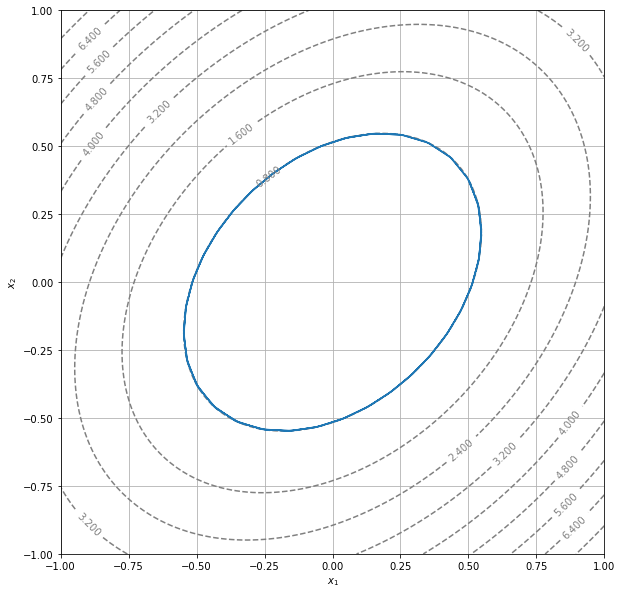

In [23]:
"""Fonction f1, courbe de niveau 0.8"""
M = Newton(F1, 0.8, 0.8) #point de départ
L = level_curve(f1, M[0], M[1])

x=np.linspace(-1.0, 1.0, 100)
y=np.linspace(-1.0, 1.0, 100)

display_contour(f1, x, y, levels=10)
plt.plot(L[0],L[1])
plt.show()

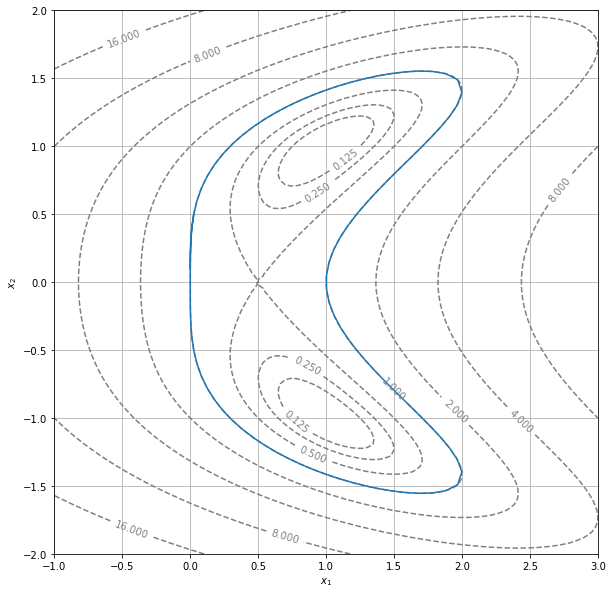

In [38]:
"""Fonction f2, courbe de niveau 1"""

M = Newton(F4, 0.8, 0.8) #point de départ
L = level_curve(f2, M[0], M[1])

x=np.linspace(-1.0, 3.0, 100)
y=np.linspace(-2.0, 2.0, 100)

display_contour(f2, x, y, levels=[2**i for i in range(-3, 8)])
plt.plot(L[0],L[1])
plt.show()

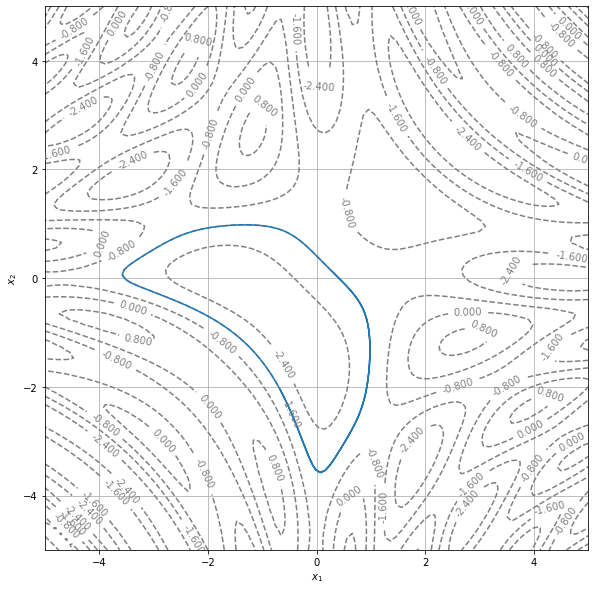

In [32]:
"""Fonction f3, courbe de niveau -1.6"""

def F6(x, y):
    return F(f3, -1.6, cond1, x, y)

M = Newton(F6, 0.0, 0.0) #point de départ
L = level_curve(f3, M[0], M[1], N=200)  #N=100 ne ferme pas la courbe

x=np.linspace(-5.0, 5.0, 100)
y=np.linspace(-5.0, 5.0, 100)

display_contour(f3, x, y, levels=5)
plt.plot(L[0],L[1])
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

#### Réponse 7
On ne trouve des courbes "auto-intersectantes" que dans le cas où il y a plusieurs maximums (ou plusieurs minimums), et même dans ce cas, il n'y aura qu'une seule courbe de niveau concernée. Ainsi, il n'est pas nécessaire de tester l'intersection du dernier segment avec tous les segments déjà produits.\
Cependant, nous avons écrit les deux programmes et comparé les temps d'execution : ils sont similaires.

#### Réponse à la tâche 4
Soit $A:(x_a,y_a), B:(x_b,y_b), C:(x_c,y_c), D:(x_d,y_d)$.
- Soit $\overrightarrow{AB}$ et $\overrightarrow{CD}$ sont colinéaires ($(y_c-y_d)(x_a-x_b)-(x_c-x_d)(y_a-y_b) = 0$), et alors on doit simplement vérifier si $C$ ou $D$ appartient à $\left[AB\right]$
- Soit $\overrightarrow{AB}$ et $\overrightarrow{CD}$ ne sont pas colinéaires ($(y_c-y_d)(x_a-x_b)-(x_c-x_d)(y_a-y_b) \neq 0$), et alors:\
Comme tout point de $(AB)$ s'écrit $u(x_a,y_a) + (1-u)(x_b,y_b)$ et tout point de $(CD)$ s'écrit $v(x_c,y_c) + (1-v)(x_d,y_d)$ et que $(AB)$ et $(BC)$ s'intersectent, il existe $u$ et $v$ tels que $u(x_a,y_a) + (1-u)(x_b,y_b)=v(x_c,y_c) + (1-v)(x_d,y_d)$. En résolvant le système on a :
$$
\begin{cases}
u= \frac{(x_c-x_b)(y_d-y_b)+(x_b-x_d)(y_c-y_b)}{(y_a-y_b)(x_c-x_d)-(x_a-x_b)(y_c-y_d)}\\
v= \frac{(x_a-x_d)(y_b-y_d)+(x_d-x_b)(y_a-y_d)}{(y_c-y_d)(x_a-x_b)-(x_c-x_d)(y_a-y_b)}
\end{cases}
$$\
Ce point appartient aux segments $\left[AB\right]$ et $\left[CD\right]$ si et seulement si $u \in \left[0,1\right] $ et $ v \in \left[0,1\right] $

In [39]:
def intersecte(za, zb, zc, zd):
    xa, ya = za
    xb, yb = zb
    xc, yc = zc
    xd, yd = zd
    d=(ya-yb)*(xc-xd)-(xa-xb)*(yc-yd)
    if d == 0:
        if xa == xb:
            if xc == xa and yc<=max(ya,yb) and yc>=min(ya,yb): return True
        elif ya == yb:
            if yc == ya and xc<=max(xa,xb) and yc>=min(xa,xb): return True
        else:
            uc=(xc-xb)/(xa-xb)
            vc=(yc-yb)/(ya-yb)
            ud=(xd-xb)/(xa-xb)
            vd=(yd-yb)/(ya-yb)
            if uc == vc or ud == vd: 
                return True        
    else:
        u=((xc-xb)*(yd-yb)+(xb-xd)*(yc-yb))/d
        v=-((xa-xd)*(yb-yd)+(xd-xb)*(ya-yd))/d
        if u >= 0 and u <= 1 and v >= 0 and v <= 1:
            return True
        else:
            return False

Les segments rouge et vert s'intersectent
Les segments bleu et vert ne s'intersectent pas
Les segments jaune et noir s'intersectent


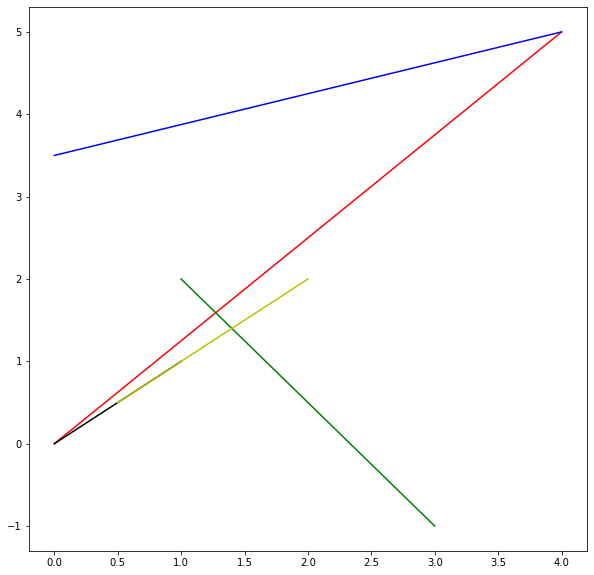

In [40]:
za = (0, 0)
za2 = (0, 3.5)
zb = (4, 5)
zc = (1, 2)
zd = (3, -1)

zb2 = (1, 1)
zc2 = (0.5, 0.5)
zd2 = (2, 2)

if intersecte(za, zb, zc, zd): 
    print("Les segments rouge et vert s'intersectent")
else:
    print("Les segments rouge et vert ne s'intersectent pas")

if intersecte(za2, zb, zc, zd): 
    print("Les segments bleu et vert s'intersectent")
else:
    print("Les segments bleu et vert ne s'intersectent pas")
    
if intersecte(za, zb2, zc2, zd2): 
    print("Les segments jaune et noir s'intersectent")
else:
    print("Les segments jaune et noir ne s'intersectent pas")

xab = np.linspace(za[0], zb[0], 100)
yab = np.linspace(za[1], zb[1], 100)
xab2 = np.linspace(za2[0], zb[0], 100)
yab2 = np.linspace(za2[1], zb[1], 100)
xcd = np.linspace(zc[0], zd[0], 100)
ycd = np.linspace(zc[1], zd[1], 100)
xab3 = np.linspace(za[0], zb2[0], 100)
yab3 = np.linspace(za[1], zb2[1], 100)
xcd2 = np.linspace(zc2[0], zd2[0], 100)
ycd2 = np.linspace(zc2[1], zd2[1], 100)

plt.plot(xab, yab, 'r-')
plt.plot(xab2, yab2, 'b-')
plt.plot(xcd, ycd, 'g-')
plt.plot(xab3, yab3, 'k-')
plt.plot(xcd2, ycd2, 'y-')
plt.show()

In [41]:
def level_curve2_tous_segments(f, x0, y0, delta=0.1, eps=eps):
    X=[]
    Y=[]
    B = False
    i = 0

    while B == False:
        g = grad(f)(x0, y0)
        rotation = np.array([[0, 1],[-1, 0]])
        u = np.dot(rotation,g)
        xd, yd = np.array([x0, y0]) + delta * u / (np.linalg.norm(u))
        
        def cond4(x, y):
            return (x - x0)**2 + (y - y0)**2 - delta**2

        def F5(x, y):
            return F(f, f(x0, y0), cond4, x, y)
    
        newt = Newton(F5 ,xd, yd)
        x0, y0 = newt[0], newt[1]
        X.append(x0)
        Y.append(y0)
        for j in range(i-2):
            if intersecte((X[j], Y[j]),(X[j+1], Y[j+1]),(X[i-1], Y[i-1]),(x0, y0)):
                B = True
        i+=1
    return [X,Y]

In [65]:
def level_curve2(f, x0, y0, delta=0.1, eps=eps):
    X=[]
    Y=[]
    B = False
    i = 0

    while B == False:
        g = grad(f)(x0, y0)
        rotation = np.array([[0, 1],[-1, 0]])
        u = np.dot(rotation,g)
        xd, yd = np.array([x0, y0]) + delta * u / (np.linalg.norm(u))
        
        def cond4(x, y):
            return (x - x0)**2 + (y - y0)**2 - delta**2

        def F5(x, y):
            return F(f, f(x0, y0), cond4, x, y)
    
        newt = Newton(F5 ,xd, yd)
        x0, y0 = newt[0], newt[1]
        X.append(x0)
        Y.append(y0)
        if i >= 3 and intersecte((X[0], Y[0]), (X[1], Y[1]), (X[i-1], Y[i-1]), (x0, y0)):
            B = True
        i+=1
    return [X,Y]

#import timeit
#def F6(x, y):
#    return F(f3, -1.6, cond1, x, y)
#M = Newton(F6, 0.0, 0.0) #point de départ
#print(timeit.timeit(lambda : level_curve2_tous_segments(f3, M[0], M[1]), number = 10)/10)  #résultat : 2.466s
#print(timeit.timeit(lambda : level_curve2(f3, M[0], M[1]), number = 10)/10)  #résultat : 2.538s

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

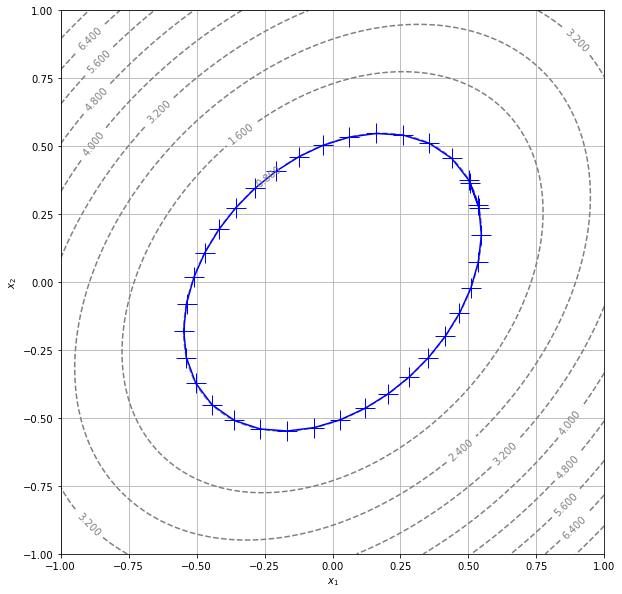

In [66]:
"""Fonction f1, courbe de niveau 0.8"""
M = Newton(F1, 0.8, 0.8) #point de départ
L = level_curve2(f1, M[0], M[1])

x=np.linspace(-1.0, 1.0, 100)
y=np.linspace(-1.0, 1.0, 100)

display_contour(f1, x, y, levels=10)
plt.plot(L[0], L[1], 'b-+', markersize = 20)
plt.show()

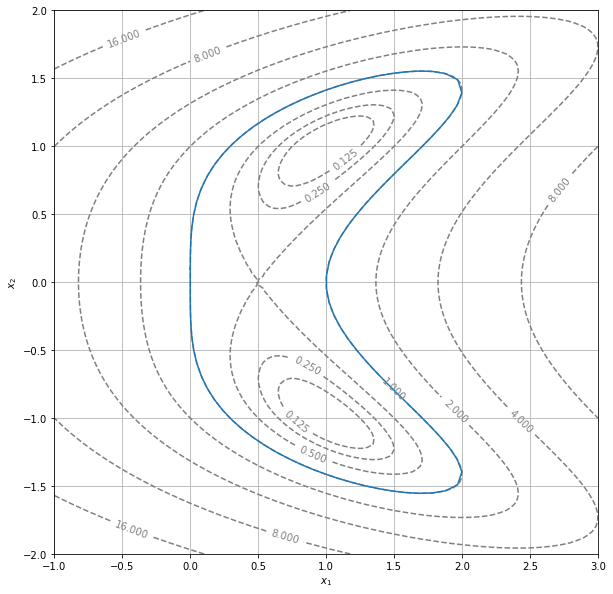

In [67]:
"""Fonction f2, courbe de niveau 1"""

M = Newton(F4, 0.8, 0.8) #point de départ
L = level_curve2(f2, M[0], M[1])

x=np.linspace(-1.0, 3.0, 100)
y=np.linspace(-2.0, 2.0, 100)

display_contour(f2, x, y, levels=[2**i for i in range(-3, 8)])
plt.plot(L[0], L[1])
plt.show()

In [68]:
def level_curve2_trouee(f, x0, y0, delta=0.1, eps=eps):
    X=[]
    Y=[]
    B = False
    i = 0

    while B == False:
        g = grad(f)(x0, y0)
        rotation = np.array([[0, 1],[-1, 0]])
        u = np.dot(rotation,g)
        xd, yd = np.array([x0, y0]) + delta * u / (np.linalg.norm(u))
        
        def cond4(x, y):
            return (x - x0)**2 + (y - y0)**2 - delta**2

        def F5(x, y):
            return F(f, f(x0, y0), cond4, x, y)
    
        newt = Newton(F5 ,xd, yd)
        x0, y0 = newt[0], newt[1]
        X.append(x0)
        Y.append(y0)
        for j in range(i-2):
            if intersecte((X[j], Y[j]),(X[j+1], Y[j+1]),(X[i-1], Y[i-1]),(x0, y0)):
                B = True
        i+=1
    X.pop()  #on enlève les deux derniers segments
    X.pop()
    Y.pop()
    Y.pop()
    return [X,Y]

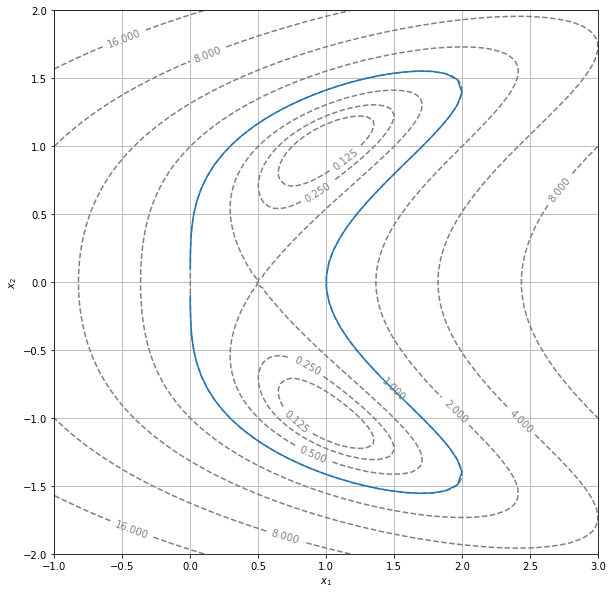

In [69]:
"""Fonction f2, courbe de niveau 1, trouée"""

M = Newton(F4, 0.8, 0.8) #point de départ
L = level_curve2_trouee(f2, M[0], M[1])

x=np.linspace(-1.0, 3.0, 100)
y=np.linspace(-2.0, 2.0, 100)

display_contour(f2, x, y, levels=[2**i for i in range(-3, 8)])
plt.plot(L[0],L[1])
plt.show()

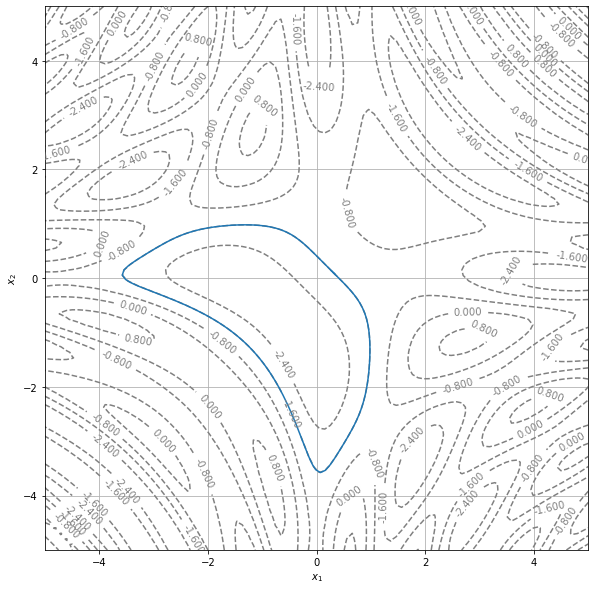

In [70]:
"""Fonction f3, courbe de niveau -1.6"""

def F6(x, y):
    return F(f3, -1.6, cond1, x, y)

M = Newton(F6, 0.0, 0.0) #point de départ
L = level_curve2(f3, M[0], M[1])

x=np.linspace(-5.0, 5.0, 100)
y=np.linspace(-5.0, 5.0, 100)

display_contour(f3, x, y, levels=5)
plt.plot(L[0],L[1])
plt.show()

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse 8

On cherche à déterminer les coefficients $a, b, c, d, e, f$ solutions du problèmes et les expliciter en fonction de $P_1$, $P_2$, $u_1$ et $u_2$.

On note leur coordonnées:
$P_1 = (x_{p1}, y_{p1})$ \;
$P_2 = (x_{p2}, y_{p2})$ \;
$u_1 = (x_{u1}, y_{u2})$ \;
$u_2 = (x_{u2}, y_{u2})$


On a les conditions : $\gamma(0) = P_1 \Leftrightarrow
\left\{\begin{matrix}
a=x_{p1}\\
d=y_{p1}
\end{matrix}\right.$

et $\gamma(1) = P_2 \Leftrightarrow \left\{\begin{matrix}
a+b+c=x_{p2}\\
d+e+f=y_{p2}
\end{matrix}\right.  (1)$

De plus on sait que   $\gamma'(0)$  est dans la même direction et le même sens que  $u_1$  et  $\gamma'(1)$  soit dans la même direction et le même sens que  $u_2$, c'est-à-dire qu'il existe
$\alpha$ et $\beta$ des réels positifs tels que: $\left\{\begin{matrix}
\gamma'(0)=\alpha u_1\\
\gamma'(1)=\beta u_2
\end{matrix}\right.$
$\Leftrightarrow \left\{\begin{matrix}
b=\alpha x_{u1}\\
e=\alpha y_{u1}\\
b + 2c = \beta x_{u2}\\
e +2f = \beta y_{u2}
\end{matrix}\right.$ $\Leftrightarrow \left\{\begin{matrix}
b=\alpha x_{u1}\\
e=\alpha y_{u1}\\
\alpha x_{u1} + 2c = \beta x_{u2}\\
\alpha y_{u1} +2f = \beta y_{u2}
\end{matrix}\right.$ (2)


$ (1)\Leftrightarrow \left\{\begin{matrix}
c= x_{P2}-x_{P1}-\alpha x_{u1}\\
f= y_{P2}-y_{P1}-\alpha y_{u1}
\end{matrix}\right. $

$(2)\Leftrightarrow \left\{\begin{matrix}
\alpha x_{u1} + 2x_{P2}-2x_{P1}-2\alpha x_{u1} = \beta x_{u2}\\
\alpha y_{u1} +2y_{P2}-2y_{P1}-2\alpha y_{u1} = \beta y_{u2}
\end{matrix}\right.$
$\\
\Leftrightarrow \left\{\begin{matrix}
2x_{P2}-2x_{P1}-\alpha x_{u1} = \beta x_{u2}\\
2y_{P2}-2y_{P1}-\alpha y_{u1} = \beta y_{u2}
\end{matrix}\right.$
$\\
\Leftrightarrow \left\{\begin{matrix}
\alpha x_{u1} + \beta x_{u2} = 2(x_{P2}-x_{P1})\\
\alpha y_{u1} + \beta y_{u2} = 2(y_{P2}-y_{P1})
\end{matrix}\right.$

Pour que ce système ait une solution, il faut que le déterminant de la matrice $ \begin{pmatrix}
x_{u1} & x_{u2}\\
y_{u1} & y_{u2}
\end{pmatrix}$ soit non nul, c'est-à-dire :

$ det \begin{pmatrix}
x_{u1} & x_{u2}\\
y_{u1} & y_{u2}
\end{pmatrix}  = x_{u1}y_{u2}- x_{u2}y_{u1} \neq 0 $, ce qui revient à dire $u_1$ et $u_2$ non colinéaires.

Dans ce cas-là, on résout le système et on trouve comme forme de solution :

$\alpha = 2 \frac{det\begin{pmatrix}
x_{P2}-x_{P1} & x_{u2}\\
y_{P2}-y_{P1} & y_{u2}
\end{pmatrix}}{det(u1,u2)}=2 \frac{y_{u2}(x_{P2}-x_{P1})-x_{u2}(y_{P2}-y_{P1})}{x_{u1}y_{u2}- x_{u2}y_{u1}} $ et
$
\beta = 2 \frac{det\begin{pmatrix}
 x_{u1} &x_{P2}-x_{P1}\\
 y_{u1} &y_{P2}-y_{P1}
\end{pmatrix}}{det(u1,u2)}=2 \frac{x_{u1}(y_{P2}-y_{P1})-y_{u1}(y_{P2}-y_{P1})}{x_{u1}y_{u2}- x_{u2}y_{u1}}$


Ainsi, $\left\{\begin{matrix}
a=x_{p1}\\
b=\alpha x_{u1} \\
c=\frac{\beta x_{u2} - \alpha x_{u1}}{2} \\
d=y_{p1}\\
e=\alpha y_{u1} \\
f =\frac{\beta y_{u2} - \alpha y_{u1}}{2} \\
\end{matrix}\right.$

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




#### Réponse à la tâche 6

Pour la suite on utilise le fait $u_1$ doit être colinéaire à $\gamma'(0)$ et que $u_2$ doit l'être à $\gamma'(1)$:
$\left\{\begin{matrix}
y_{u1}b - x_{u1}e = 0\\ 
y_{u2}(b+2c)-x_{u2}(e+2f)  = 0
\end{matrix}\right. $

Ce qui nous donne le système :
$\left\{\begin{matrix}
b+c = x_{P2}-x_{P1}\\
e+f = y_{P2}-y_{P1}\\
y_{u1}b - x_{u1}e = 0\\ 
y_{u2}(b+2c)-x_{u2}(e+2f)  = 0
\end{matrix}\right.$

En posant A la matrice 4x4:

$A = \begin{pmatrix}
 1& 1 & 0 & 0\\ 
0 & 0 & 1 & 1\\ 
y_{u1} & 0 & -x_{u1} & 0\\ 
 y_{u2}& 2y_{u2} &-x_{u2}  & -2x_{u2}
\end{pmatrix}$
et $ B = \begin{pmatrix}
x_{P2}-x_{P1}\\ 
y_{P2}-y_{P1}\\ 
0\\ 
0
\end{pmatrix}$, le vecteur $ V= \begin{pmatrix}
b\\ 
c\\ 
e\\ 
f
\end{pmatrix}$ est solution, si elle existe, de l'équation : $AV=B$.

Et c'est ce que nous allons exploiter pour créer notre fonction `gamma`. Ainsi, si le déterminant de A ($=det \begin{pmatrix}
x_{u1} & x_{u2}\\
y_{u1} & y_{u2}
\end{pmatrix}
$)
est non nul, il existe une unique solution $V$ qui résout ce système et on vérifira alors que les vecteurs $u_1$ et $\binom{b}{e}$ sont bien de même sens en regardant si leur produit scalaire est positif ou non, de même pour les vecteurs $u_2$ et $\binom{b+2c}{e+2f}$. Si toutes ces conditions sont respectées, la fonction `gamma` renverra les points associés à la forme souhaitée, ou les points associés à un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

In [71]:
def gamma(t, P1, P2, u1, u2):
    a = P1[0]
    d = P1[1]
    G = np.empty((2, len(t)))
    A = np.array([[1, 1, 0, 0], [0, 0, 1, 1], [u1[1], 0, -u1[0], 0], [u2[1], 2*u2[1], -u2[0], -2*u2[0]]])
    B = np.array([P2[0]-P1[0], P2[1]-P1[1], 0, 0])
    
    if np.linalg.det(A) != 0:
        v = np.linalg.solve(A, B)
        w1 = (v[0], v[2])
        w2 = (v[0]+2*v[1], v[2]+2*v[3])
        
        if np.dot(u1,w1) > 0 and np.dot(u2, w2):
            return [a+v[0]*t+v[1]*t**2, d+v[2]*t+v[3]*t**2]
        else:
            return P1[0]+(P2[0]-P1[0])*t, P1[1]+(P2[1]-P1[1])*t
    else:
        return P1[0]+(P2[0]-P1[0])*t, P1[1]+(P2[1]-P1[1])*t

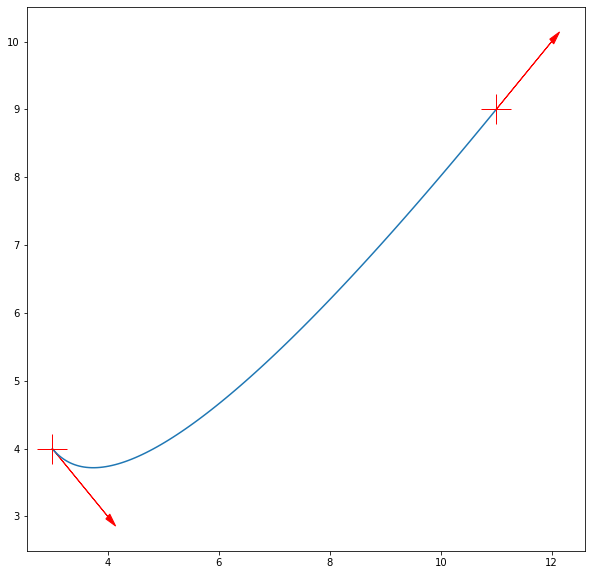

In [72]:
t = np.linspace(0, 1, 100)

"""Exemple où les vecteurs ne sont pas colinéaires"""

P1 = [3, 4]
P2 = [11, 9]
u1 = [1, -1]
u2 = [1, 1]

g = gamma(t, P1, P2, u1, u2)

axe = plt.axes()
axe.arrow(P1[0], P1[1], u1[0], u1[1], head_width = 0.1, head_length = 0.2, fc = 'r', ec = 'r')
axe.arrow(P2[0], P2[1], u2[0], u2[1], head_width = 0.1, head_length = 0.2, fc = 'r', ec = 'r')
plt.plot(g[0], g[1])
plt.plot(P1[0], P1[1],'r+', markersize=30)
plt.plot(P2[0], P2[1],'r+', markersize=30)

plt.show()

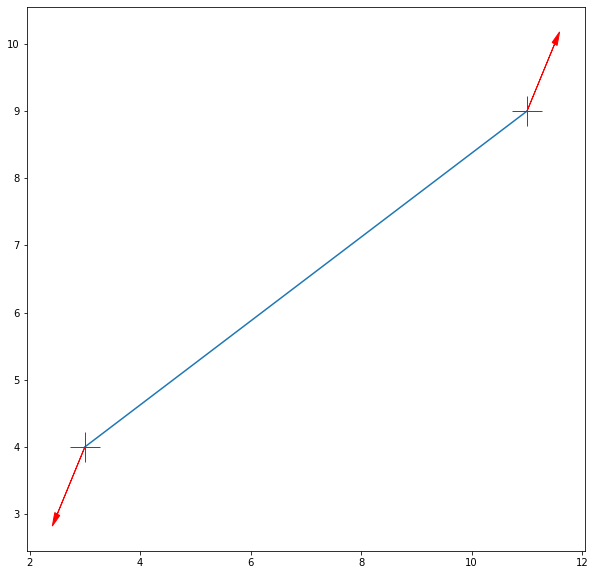

In [73]:
t = np.linspace(0, 1, 100)

"""Exemple où les vecteurs ne sont pas colinéaires"""

P1 = [3, 4]
P2 = [11, 9]
u1 = [-0.5, -1]
u2 = [0.5, 1]

g = gamma(t, P1, P2, u1, u2)

axe = plt.axes()
axe.arrow(P1[0], P1[1], u1[0], u1[1], head_width = 0.1, head_length = 0.2, fc = 'r', ec = 'r')
axe.arrow(P2[0], P2[1], u2[0], u2[1], head_width = 0.1, head_length = 0.2, fc = 'r', ec = 'r')
plt.plot(g[0], g[1])
plt.plot(P1[0], P1[1],'r+', markersize=30)
plt.plot(P2[0], P2[1],'r+', markersize=30)

plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [74]:
def level_curve3(f, x0, y0, oversampling, delta=0.1, eps=eps):
    L = level_curve2(f, x0, y0, delta=0.1, eps=eps)
    
    n = len(L[0])
    
    X = []
    Y = []
    
    for i in range(n-1):
        grad1 = grad(f)(L[0][i], L[1][i])
        grad2 = grad(f)(L[0][i+1], L[1][i+1])
        
        rotation = np.array([[0, 1], [-1, 0]])
        
        u1 = np.dot(rotation, grad1)
        u2 = np.dot(rotation, grad2)
        
        t = np.linspace(0, 1, oversampling + 1)
        
        g = gamma(t, (L[0][i], L[1][i]), (L[0][i+1], L[1][i+1]), u1, u2)
                 
        for j in range(oversampling):
            X.append(g[0][j])
            Y.append(g[1][j])
        
    return X, Y

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

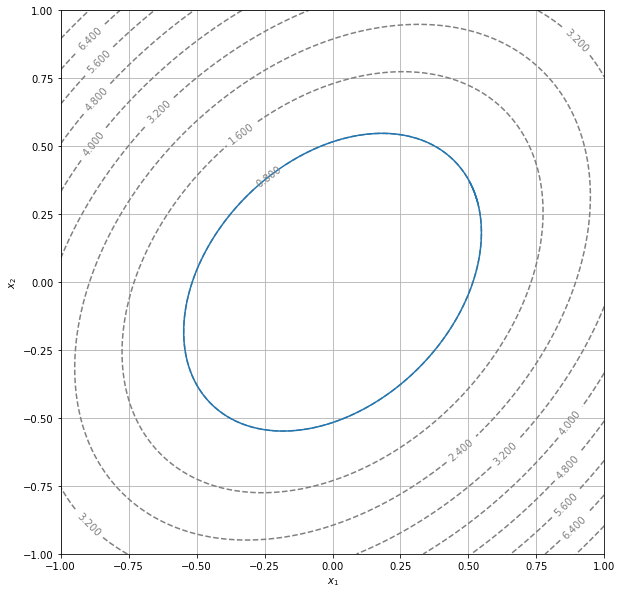

In [75]:
"""Fonction f1, courbe de niveau 0.8"""
M = Newton(F1, 0.8, 0.8) #point de départ
L = level_curve3(f1, M[0], M[1], 10)

x=np.linspace(-1.0, 1.0, 100)
y=np.linspace(-1.0, 1.0, 100)

display_contour(f1, x, y, levels=10)
plt.plot(L[0],L[1])
plt.show()

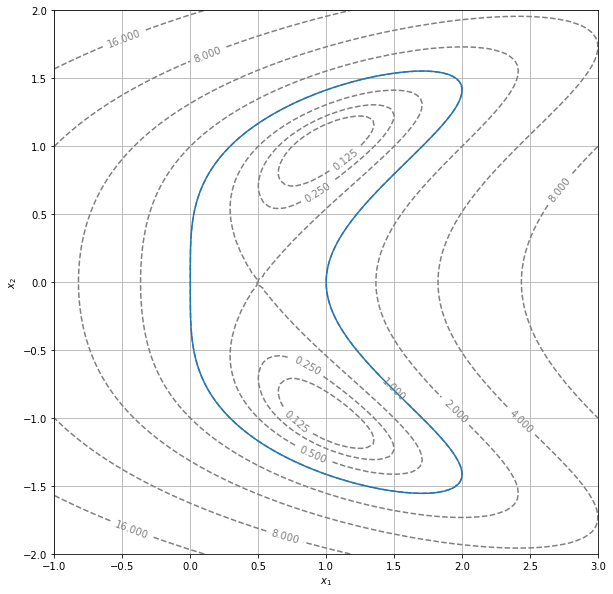

In [76]:
"""Fonction f2, courbe de niveau 1"""

M = Newton(F4, 0.8, 0.8) #point de départ
L = level_curve3(f2, M[0], M[1], 10)

x=np.linspace(-1.0, 3.0, 100)
y=np.linspace(-2.0, 2.0, 100)

display_contour(f2, x, y, levels=[2**i for i in range(-3, 8)])
plt.plot(L[0],L[1])
plt.show()

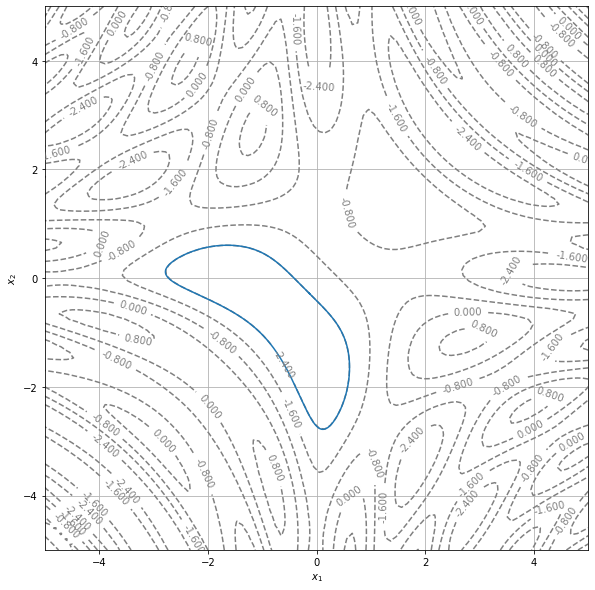

In [87]:
"""Fonction f3, courbe de niveau -2.4"""

def F6(x, y):
    return F(f3, -2.4, cond1, x, y)

M = Newton(F6, 0.0, 0.0) #point de départ
L = level_curve3(f3, M[0], M[1], 10)

x=np.linspace(-5.0, 5.0, 100)
y=np.linspace(-5.0, 5.0, 100)

display_contour(f3, x, y, levels=5)
plt.plot(L[0],L[1])
plt.show()

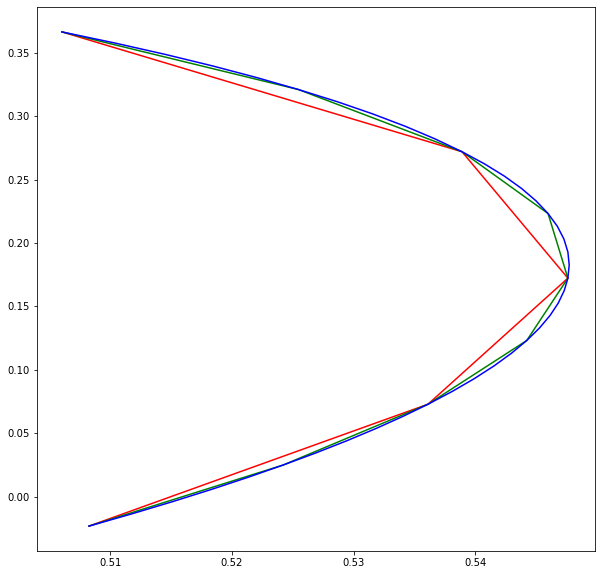

In [88]:
"""Comparaison de level_curve2 et level_curve3 avec différents paramètres sur les 5 premiers points de la fonction"""

M = Newton(F1, 0.8, 0.8)
L3_10 = level_curve3(f1, M[0], M[1], 10)
L3_2 = level_curve3(f1, M[0], M[1], 2)
L2 = level_curve2(f1, M[0], M[1])

x=np.linspace(-1.0, 1.0, 100)
y=np.linspace(-1.0, 1.0, 100)

plt.plot(L2[0][:5:], L2[1][:5:], 'r-') #résultat de level_curve2 affiché en rouge
plt.plot(L3_2[0][:9:], L3_2[1][:9:], 'g-') #résultat de level_curve3 avec oversampling = 2 affiché en vert
plt.plot(L3_10[0][:41:], L3_10[1][:41:], 'b-') #résultat de level_curve3 avec oversampling = 10 affiché en bleu
plt.show()